# Assignment Two: Bayesian Inference Using MCMC

## William Koehrsen wjk68

### Exercise 1

#### A. Bayesian Belief Network with Discrete Varibles

For a simple example, I created a belief network representing the probability of getting a raise based on several variables. All of the variables in the network are discrete and the entire joint probability can be specified using priors and conditional probability tables. 

The entire network is shown below:

![image](images/Raise Network.png)

The top level variables show the prior probabilities in the node. The other probabilities we need to specify are the conditionals for the mid-level nodes (Boss's Mood and Profits) and the final node (Raise). All of these variables depend on two parent variables, with the mid level nodes have 6 entries in the conditional probability table (representing all possible states of the parents) and the Raise node having four entries in the conditional probability table. The tables are presented below:

<h4><center>Conditional Probability of Boss's Mood</center></h4>

| Weather | Personal Performance | P(Mood = Positive) |
|---------|----------------------|--------------------|
| 0       | 0                    | 0.15               |
| 0       | 1                    | 0.55               |
| 1       | 0                    | 0.45               |
| 1       | 1                    | 0.85               |
| 2       | 0                    | 0.35               |
| 2       | 1                    | 0.75               |



<h4><center>Conditional Probability of Company Performance</center></h4>

| Company Revenue | Personal Performance | P(Company Performance = Profit) |
|-----------------|----------------------|---------------------------------|
| 0               | 0                    | 0.05                            |
| 0               | 1                    | 0.10                            |
| 1               | 0                    | 0.75                            |
| 1               | 1                    | 0.95                            |
| 2               | 0                    | 0.20                            |
| 2               | 1                    | 0.40                            |



<h4><center>Conditional Probability of Raise</center></h4>

| Boss's Mood | Company Performance | P(Raise = True) |
|-------------|---------------------|-----------------|
| 0           | 0                   | 0.05            |
| 0           | 1                   | 0.65            |
| 1           | 0                   | 0.40            |
| 1           | 1                   | 0.90            |


With the prior probabilities and the conditional probabilities, we can compute the entire joint probability of the network. We can also use Markov Chain Monte Carlo to approximate the posterior probabilities of any variables in the network with or without observations.

## Discrete Bayesian Network in PyMC3

The first approach to solve this network uses a Markov Chain Monte Carlo algorithm to find approximate probabilities. MCMC works by sampling from the posterior distribution to find an approximation of the posterior and the accuracy increases as the number of samples increases. PyMC3 implements Bayesian Reasoning by constructing a graph of the network and then evaluating the graph during the sampling process. In this problem we have only two kinds of variables: binary (taking on two values), and discrete (in this case taking on 3 values). We can build up the graph and then query it find the approximate probabilities without and then with evidence (observations).

In [1]:
import numpy as np
import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline

import theano.tensor as tt


import seaborn as sns

from IPython.core.pylabtools import figsize

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Construct the Model Graph

In [2]:
N_SAMPLES = 1000
N_CHAINS = 2

with pm.Model() as raise_model:
    
    # Weather is a categorical variable with 3 states
    weather = pm.Categorical('weather', np.array([0.3, 0.4, 0.3]))
    
    # Personal Performance is a Bernoulli Variable with 2 states
    pp = pm.Bernoulli('pp', 0.8)
    
    # Company Revenue is a categorical variable with 3 states
    revenue = pm.Categorical('revenue', np.array([0.4, 0.4, 0.2]))
    
    # Boss's Mood Conditional Probability Definition
    mood = pm.Bernoulli('mood', tt.switch(tt.eq(weather, 0), tt.switch(tt.eq(pp, 0), 0.15, 0.55), 
                                          tt.switch(tt.eq(weather, 1), tt.switch(tt.eq(pp, 0), 0.45, 0.85), 
                                                                       tt.switch(tt.eq(pp, 0), 0.35, 0.75))))
    
    # Company Performance Conditional Probability Definition
    cp = pm.Bernoulli('cp', tt.switch(tt.eq(revenue, 0), tt.switch(tt.eq(pp, 0), 0.05, 0.10),
                                      tt.switch(tt.eq(revenue, 1), tt.switch(tt.eq(pp, 0), 0.75, 0.95),
                                                            tt.switch(tt.eq(pp, 0), 0.20, 0.40))))
    
    # Raise is a Bernoulli Variable with 2 states
    raise_ = pm.Bernoulli('raise_', tt.switch(tt.eq(mood, 0), tt.switch(tt.eq(cp, 0), 0.05, 0.65),
                                                              tt.switch(tt.eq(cp, 0), 0.40, 0.90)))
                                 

### Sample from the Posterior Using MCMC (Gibbs Metropolis Algorithm)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [revenue, weather]
>BinaryGibbsMetropolis: [pp, mood, cp, raise_]
The number of effective samples is smaller than 25% for some parameters.


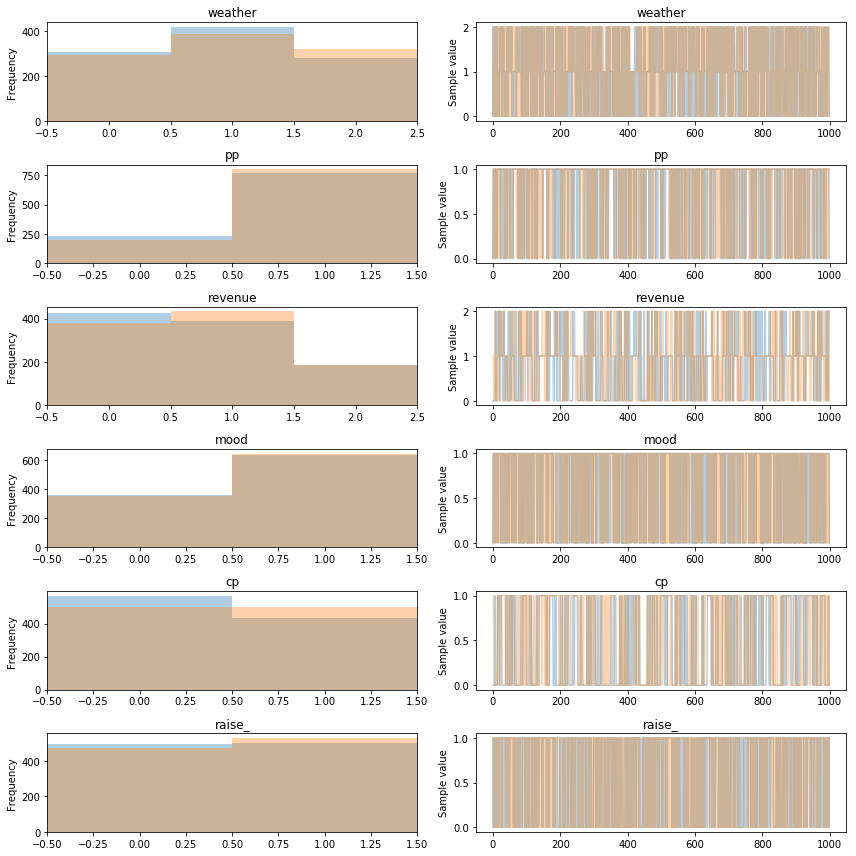

In [3]:
with raise_model:
    # Sample and plot traces
    raise_trace = pm.sample(draws=N_SAMPLES, chains=N_CHAINS)
    pm.traceplot(raise_trace)

## Evaluate the Trace to Find Probabilities

In [58]:
def query_model(trace, obs={}, compare=False):
    if 'weather' in obs.keys():
        f_rain = obs['weather'].get('rain', 0)
        f_sun = obs['weather'].get('sun', 0)
        f_snow = obs['weather'].get('snow', 0)
        
    else:
        f_rain = np.mean(trace['weather'] < 0.5)
        f_sun = np.mean((trace['weather'] >= 0.5) & (trace['weather'] <= 1.5))
        f_snow = np.mean(trace['weather'] > 1.5)
    
    print('Approximate Probabilities from MCMC:')
    print("""\nWeather: {:.2f}, {:.2f}, {:.2f}.""".format(
              f_rain, f_sun, f_snow))
    
    if 'pp' in obs.keys():
        f_pp_above = obs['pp'].get('pp')
    
    else:
        f_pp_above = np.mean(trace['pp'] >= 0.5)
        
    f_pp_below = 1 - f_pp_above
    print("""Personal Performance: {:.2f}, {:.2f}""".format(
             f_pp_below, f_pp_above))
    
    if 'revenue' in obs.keys():
        f_revenue_below = obs['revenue'].get('below', 0)
        f_revenue_above = obs['revenue'].get('above', 0)
        f_revenue_neutral = obs['revenue'].get('neutral', 0)
        
    else:
        f_revenue_below = np.mean(trace['revenue'] < 0.5)
        f_revenue_above = np.mean((trace['revenue'] >= 0.5) & (trace['revenue'] <= 1.5))
        f_revenue_neutral = np.mean(trace['revenue'] > 1.5)
    print("""Revenue: {:.2f}, {:.2f}, {:.2f}.""".format(
              f_revenue_below, f_revenue_above, f_revenue_neutral))
    
    if 'mood' in obs.keys():
        f_mood_positive = obs['mood'].get('mood')
    else:
        f_mood_positive = np.mean(trace['mood'] >= 0.5)
    
    f_mood_negative = 1 - f_mood_positive
    print("""Boss's mood: {:.2f}, {:.2f}.""".format(
        f_mood_negative, f_mood_positive))
    
    if 'cp' in obs.keys():
        f_profits = obs['cp'].get('cp')
    else:
        f_profits = np.mean(trace['cp'] >= 0.5)
    
    f_loss = 1 - f_profits
    
    print("""Profits: {:.2f}, {:.2f}.""".format(
        f_loss, f_profits))
    
    if 'raise' in obs.keys():
        f_raise = obs['raise'].get('raise')
        
    else:
        f_raise = np.mean(trace['raise_'] >= 0.5)
    
    print("""\nProbability of a raise: {:.4f}.""".format(f_raise))
    
    if compare:
        return [f_rain, f_sun, f_snow, f_pp_above, f_revenue_below, 
                f_revenue_above, f_revenue_neutral, f_mood_positive,
                f_profits, f_raise]

### Approximate Probabilities with No Evidence

In [59]:
query_model(raise_trace)

Approximate Probabilities from MCMC:

Weather: 0.30, 0.40, 0.30.
Personal Performance: 0.21, 0.79
Revenue: 0.40, 0.41, 0.19.
Boss's mood: 0.36, 0.64.
Profits: 0.53, 0.47.

Probability of a raise: 0.5155.


## Model that Accounts for Observations

In [12]:
def model_with_evidence(weather_obs=None, pp_obs=None, revenue_obs=None,
                        mood_obs=None, cp_obs=None, raise_obs=None):
    
    with pm.Model() as raise_model:
    
        # Weather is a categorical variable with 3 states
        weather = pm.Categorical('weather', np.array([0.3, 0.4, 0.3]), 
                                 observed = weather_obs)

        # Personal Performance is a Bernoulli Variable with 2 states
        pp = pm.Bernoulli('pp', 0.8, observed = pp_obs)

        # Company Revenue is a categorical variable with 3 states
        revenue = pm.Categorical('revenue', np.array([0.4, 0.4, 0.2]), 
                                 observed = revenue_obs)

        # Boss's Mood Conditional Probability Definition
        mood = pm.Bernoulli('mood', tt.switch(tt.eq(weather, 0), tt.switch(tt.eq(pp, 0), 0.15, 0.55), 
                                              tt.switch(tt.eq(weather, 1), tt.switch(tt.eq(pp, 0), 0.45, 0.85), 
                                                                           tt.switch(tt.eq(pp, 0), 0.35, 0.75))),
                           observed = mood_obs)

        # Company Performance Conditional Probability Definition
        cp = pm.Bernoulli('cp', tt.switch(tt.eq(revenue, 0), tt.switch(tt.eq(pp, 0), 0.05, 0.10),
                                          tt.switch(tt.eq(revenue, 1), tt.switch(tt.eq(pp, 0), 0.75, 0.95),
                                                                tt.switch(tt.eq(pp, 0), 0.20, 0.40))),
                         observed = cp_obs)

        # Raise is a Bernoulli Variable with 2 states
        raise_ = pm.Bernoulli('raise_', tt.switch(tt.eq(mood, 0), tt.switch(tt.eq(cp, 0), 0.05, 0.65),
                                                                  tt.switch(tt.eq(cp, 0), 0.40, 0.90)),
                             observed = raise_obs)
        
        # Sample and plot traces
        raise_trace = pm.sample(draws=N_SAMPLES, chains=N_CHAINS)
        
        return (raise_trace)

### Approximate Probabilities with Evidence

In [13]:
above_revenue_trace = model_with_evidence(revenue_obs=1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [weather]
>BinaryGibbsMetropolis: [pp, mood, cp, raise_]


In [60]:
query_model(above_revenue_trace, obs={'revenue': {'above':1}})

Approximate Probabilities from MCMC:

Weather: 0.31, 0.39, 0.30.
Personal Performance: 0.21, 0.79
Revenue: 0.00, 1.00, 0.00.
Boss's mood: 0.35, 0.65.
Profits: 0.09, 0.91.

Probability of a raise: 0.7605.


In [92]:
good_mood_above_performance = model_with_evidence(mood_obs=1, pp_obs=1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [revenue, weather]
>BinaryGibbsMetropolis: [cp, raise_]


In [94]:
query_model(good_mood_above_performance, obs = {'mood': {'mood': 1}, 'pp': {'pp': 1}})

Approximate Probabilities from MCMC:

Weather: 0.23, 0.47, 0.30.
Personal Performance: 0.00, 1.00
Revenue: 0.40, 0.40, 0.20.
Boss's mood: 0.00, 1.00.
Profits: 0.50, 0.50.

Probability of a raise: 0.6590.


# Evaluate the Joint Probability

The other method to evaluate the network is explicity using the priors and conditional probability tables. This will allow us to find the exact posterior probability. The reason we can do explicit evaluation for this problem is because we are only using binary and discrete variables. With continuous varibles, evaluting posteriors from the joint is nearly impossible by hand and computationally intractable for large problems. 

After we instantiate the model to evaluate the joint exactly, we can compare the results to the approximate values from MCMC.

In [70]:
def joint_probability(weather_obs = None, pp_obs=None, revenue_obs=None,
                      mood_obs = None, cp_obs = None, raise_obs = None,
                     compare=False):
    
    if weather_obs==0:
        p_w_0 = 1
        p_w_1 = 0
        p_w_2 = 0
    elif weather_obs==1:
        p_w_0 = 0
        p_w_1 = 1
        p_w_2 = 0
    elif weather_obs==2:
        p_w_0 = 0
        p_w_1 = 0
        p_w_2 = 1   
    
    else:
        p_w_0 = 0.3
        p_w_1 = 0.4
        p_w_2 = 0.3
        
    print('\nExact Probabilities from the joint:')
    print("""\nWeather {:.2f}, {:.2f}, {:.2f}.""".format(
              p_w_0, p_w_1, p_w_2))
            
    if pp_obs==0:
        p_pp_0=1
        p_pp_1=0
    elif pp_obs==1:
        p_pp_0=0
        p_pp_1=1
    else:
        p_pp_0 = 0.2
        p_pp_1 = 0.8
        
    print("""Personal Performance: {:.2f}, {:.2f}.""".format(
             p_pp_0, p_pp_1))
        
    if revenue_obs==0:
        p_r_0 = 1
        p_r_1 = 0
        p_r_2 = 0
    elif revenue_obs==1:
        p_r_0 = 0
        p_r_1 = 1
        p_r_2 = 0
    elif revenue_obs==2:
        p_r_0 = 0
        p_r_1 = 0
        p_r_2 = 1 
        
    else:    
        p_r_0 = 0.4
        p_r_1 = 0.4
        p_r_2 = 0.2
        
    print("""Revenue: {:.2f}, {:.2f}, {:.2f}.""".format(
              p_r_0, p_r_1, p_r_2))
        
    if mood_obs==0:
        p_m_0=1
        p_m_1=0
    elif mood_obs==1:
        p_m_0=0
        p_m_1=1
        
    else:
        p_m_1 = (0.15 * p_w_0 * p_pp_0 +
                 0.55 * p_w_0 * p_pp_1 + 
                 0.45 * p_w_1 * p_pp_0 +
                 0.85 * p_w_1 * p_pp_1 +
                 0.35 * p_w_2 * p_pp_0 + 
                 0.75 * p_w_2 * p_pp_1)
        p_m_0 = 1 - p_m_1
        
    print("""Boss's mood: {:.2f}, {:.2f}.""".format(
        p_m_0, p_m_1))
    
    if cp_obs==0:
        p_cp_0=1
        p_cp_1=0
    elif cp_obs==1:
        p_cp_0=0
        p_cp_1=1
    
    else:
        p_cp_1 = (0.05 * p_r_0 * p_pp_0 + 
                  0.10 * p_r_0 * p_pp_1 + 
                  0.75 * p_r_1 * p_pp_0 +
                  0.95 * p_r_1 * p_pp_1 +
                  0.20 * p_r_2 * p_pp_0 +
                  0.40 * p_r_2 * p_pp_1)
        p_cp_0 = 1 - p_cp_1
        
    print("""Profits: {:.2f}, {:.2f}.""".format(
        p_cp_0, p_cp_1))
        
    if raise_obs==0:
        p_r=0
    elif raise_obs==1:
        p_r=1
    
    else:
        p_r = (0.05 * p_m_0 * p_cp_0 +
               0.65 * p_m_0 * p_cp_1 +
               0.40 * p_m_1 * p_cp_0 +
               0.90 * p_m_1 * p_cp_1) 
        
        
    print('\nProbabability of a raise: {:.4f}.'.format(p_r))
    
    if compare:
        return [p_w_0, p_w_1, p_w_2, p_pp_1, p_r_0, p_r_1, p_r_2,
                p_m_1, p_cp_1, p_r]
    
        

### Exact Posterior Probability with No Evidence

In [95]:
joint_probability()


Exact Probabilities from the joint:

Weather 0.30, 0.40, 0.30.
Personal Performance: 0.20, 0.80.
Revenue: 0.40, 0.40, 0.20.
Boss's mood: 0.35, 0.65.
Profits: 0.53, 0.47.

Probabability of a raise: 0.5300.


### Exact Posterior Probability with Evidence

In [96]:
joint_probability(pp_obs=1)


Exact Probabilities from the joint:

Weather 0.30, 0.40, 0.30.
Personal Performance: 0.00, 1.00.
Revenue: 0.40, 0.40, 0.20.
Boss's mood: 0.27, 0.73.
Profits: 0.50, 0.50.

Probabability of a raise: 0.5690.


In [97]:
joint_probability(pp_obs=1, revenue_obs=1)


Exact Probabilities from the joint:

Weather 0.30, 0.40, 0.30.
Personal Performance: 0.00, 1.00.
Revenue: 0.00, 1.00, 0.00.
Boss's mood: 0.27, 0.73.
Profits: 0.05, 0.95.

Probabability of a raise: 0.8062.


In [98]:
joint_probability(weather_obs=0, pp_obs=1, revenue_obs=1)


Exact Probabilities from the joint:

Weather 1.00, 0.00, 0.00.
Personal Performance: 0.00, 1.00.
Revenue: 0.00, 1.00, 0.00.
Boss's mood: 0.45, 0.55.
Profits: 0.05, 0.95.

Probabability of a raise: 0.7602.


In [99]:
joint_probability(revenue_obs=1)


Exact Probabilities from the joint:

Weather 0.30, 0.40, 0.30.
Personal Performance: 0.20, 0.80.
Revenue: 0.00, 1.00, 0.00.
Boss's mood: 0.35, 0.65.
Profits: 0.09, 0.91.

Probabability of a raise: 0.7644.


# Comparison of Approximate and Exact

The final step is to compare the approximate MCMC method and exact evaluation from the joint probability network. Ideally these should be in close agreement.

In [100]:
def compare(weather_obs = None, pp_obs=None, revenue_obs=None,
                      mood_obs = None, cp_obs = None, raise_obs = None):
    
    approximate_trace = model_with_evidence(weather_obs, pp_obs, revenue_obs,
                              mood_obs, cp_obs, raise_obs)
    
    obs_dict = {}
    
    if weather_obs==0:
        obs_dict['weather'] = {'rain': 1}
    elif weather_obs==1:
        obs_dict['weather'] = {'sun': 1}
    elif weather_obs==2:
        obs_dict['weather'] = {'snow': 1}
        
    if pp_obs==0:
        obs_dict['pp'] = {'pp': 0}
    elif pp_obs==1:
        obs_dict['pp'] = {'pp': 1}
        
    if revenue_obs==0:
        obs_dict['revenue'] = {'below': 1}
    elif revenue_obs==1:
        obs_dict['revenue'] = {'above': 1}
    elif revenue_obs==2:
        obs_dict['revenue'] = {'neutral': 1}
        
    if mood_obs==0:
        obs_dict['mood'] = {'mood': 0}
    elif mood_obs==1:
        obs_dict['mood'] = {'mood': 1}
        
    if cp_obs==0:
        obs_dict['cp'] = {'cp': 0}
    elif cp_obs==1:
        obs_dict['cp'] = {'cp': 1}
        
    if raise_obs==0:
        obs_dict['raise'] = {'raise': 0}
    elif raise_obs==1:
        obs_dict['raise'] = {'raise': 1}

    approximate = query_model(approximate_trace, obs_dict, compare=True)
 
    exact = joint_probability(weather_obs, pp_obs, revenue_obs,
                              mood_obs, cp_obs, raise_obs,
                             compare=True)
    
    results = pd.DataFrame({'app': approximate, 'exact': exact, 
                            'names': ['rain', 'sun', 'snow', 'personal', 
                                      'below_revenue', 'above_revenue', 'neutral_revenue',
                                      'mood', 'profits', 'raise']}) 
    
    results = results.melt(id_vars='names', value_name='Probability', 
                       var_name='Model')
    
    figsize(10, 8)
    matplotlib.rcParams['font.size'] = 18
    sns.barplot('Probability', 'names', data = results, hue='Model') 
    plt.title('Probability Comparison')
    plt.xlabel('Probability'); plt.ylabel('State');
    plt.show()
    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [revenue, weather]
>BinaryGibbsMetropolis: [pp, mood, cp, raise_]
The number of effective samples is smaller than 25% for some parameters.


Approximate Probabilities from MCMC:

Weather: 0.30, 0.40, 0.30.
Personal Performance: 0.19, 0.81
Revenue: 0.43, 0.38, 0.20.
Boss's mood: 0.34, 0.66.
Profits: 0.56, 0.44.

Probability of a raise: 0.5115.

Exact Probabilities from the joint:

Weather 0.30, 0.40, 0.30.
Personal Performance: 0.20, 0.80.
Revenue: 0.40, 0.40, 0.20.
Boss's mood: 0.35, 0.65.
Profits: 0.53, 0.47.

Probabability of a raise: 0.5300.


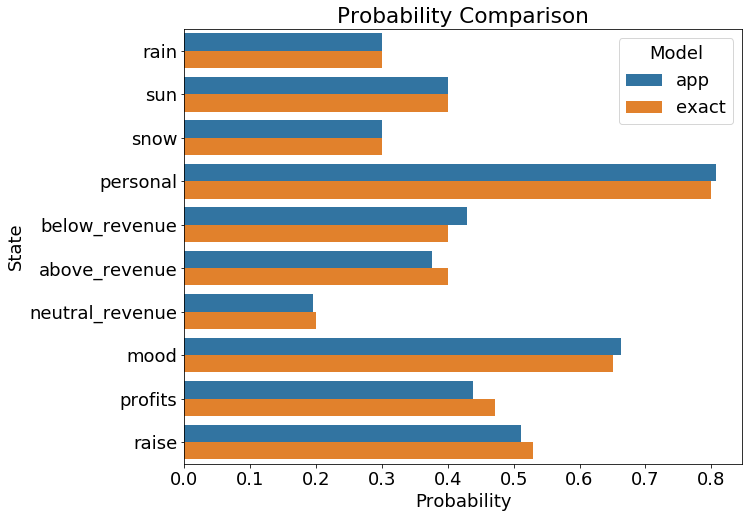

In [88]:
compare()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [pp, mood, cp, raise_]
>CategoricalGibbsMetropolis: [revenue]
The number of effective samples is smaller than 25% for some parameters.


Approximate Probabilities from MCMC:

Weather: 0.00, 0.00, 1.00.
Personal Performance: 0.20, 0.80
Revenue: 0.43, 0.38, 0.19.
Boss's mood: 0.33, 0.67.
Profits: 0.55, 0.45.

Probability of a raise: 0.5295.

Exact Probabilities from the joint:

Weather 0.00, 0.00, 1.00.
Personal Performance: 0.20, 0.80.
Revenue: 0.40, 0.40, 0.20.
Boss's mood: 0.33, 0.67.
Profits: 0.53, 0.47.

Probabability of a raise: 0.5361.


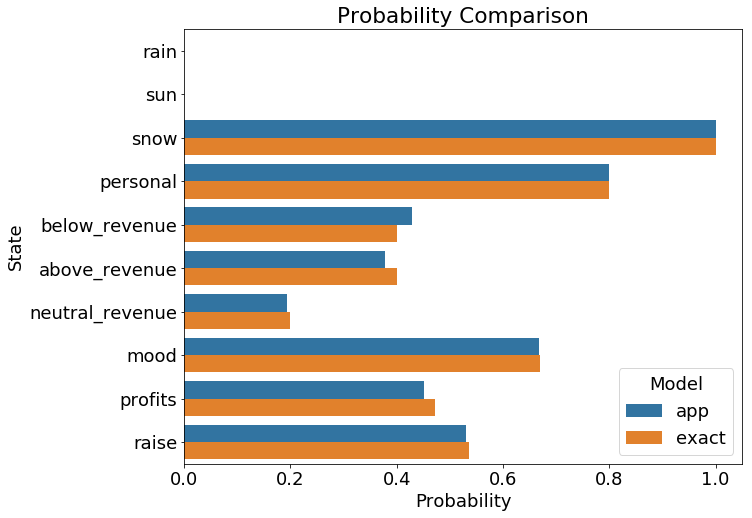

In [89]:
compare(weather_obs=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [pp, mood, raise_]
>CategoricalGibbsMetropolis: [revenue]


Approximate Probabilities from MCMC:

Weather: 1.00, 0.00, 0.00.
Personal Performance: 0.16, 0.84
Revenue: 0.08, 0.76, 0.16.
Boss's mood: 0.51, 0.49.
Profits: 0.00, 1.00.

Probability of a raise: 0.7710.

Exact Probabilities from the joint:

Weather 1.00, 0.00, 0.00.
Personal Performance: 0.20, 0.80.
Revenue: 0.40, 0.40, 0.20.
Boss's mood: 0.53, 0.47.
Profits: 0.00, 1.00.

Probabability of a raise: 0.7675.


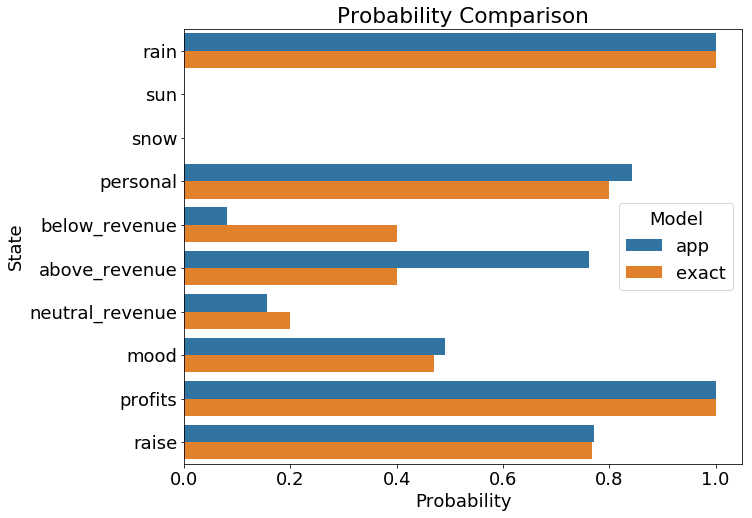

In [90]:
compare(weather_obs=0, cp_obs=1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [revenue, weather]
>BinaryGibbsMetropolis: [pp, raise_]


Approximate Probabilities from MCMC:

Weather: 0.22, 0.47, 0.31.
Personal Performance: 0.07, 0.93
Revenue: 0.08, 0.75, 0.17.
Boss's mood: 0.00, 1.00.
Profits: 0.00, 1.00.

Probability of a raise: 0.9015.

Exact Probabilities from the joint:

Weather 0.30, 0.40, 0.30.
Personal Performance: 0.20, 0.80.
Revenue: 0.40, 0.40, 0.20.
Boss's mood: 0.00, 1.00.
Profits: 0.00, 1.00.

Probabability of a raise: 0.9000.


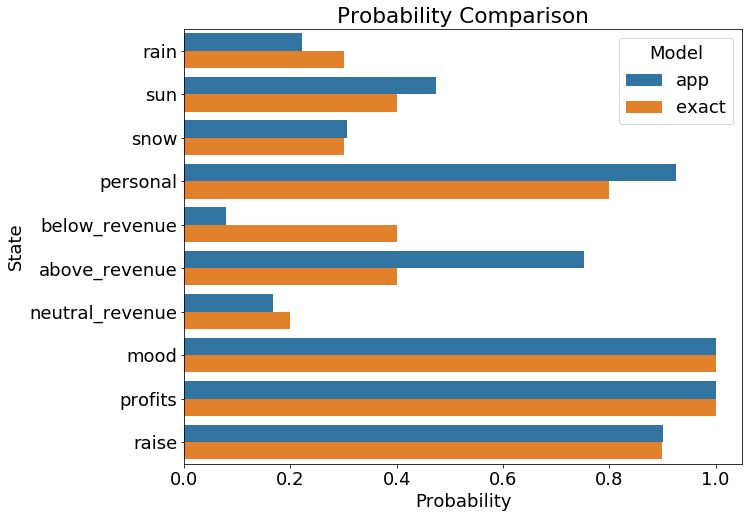

In [91]:
compare(mood_obs=1, cp_obs=1)

# Conclusions

In this notebook we looked at solving a Baye's Network using both approximate sampling methods and exact inference. Both methods agree, and for binary/discrete variables, exact inference is not out of the question. For continuous variables, approximate methods are the superior choice. Overall, MCMC methods are a rapid way to evaluate Baye's Networks and are expected to converge on the "true" posterior with enough samples. The simple problem evaluated here did not fully show the benefits of Markov Chain Monte Carlo methods, which we will explore in additional exercises using continuous variables. 